In [1]:
#https://github.com/akshatgupta95/homefindr/tree/d671cd98879a1d95e99016243ec48881cc68e723
#https://github.com/julialintern/GA_Projects/blob/a3e68c8b1f725d840f733e2919c57728c70d49b6/zillow_Final_project.ipynb
#https://github.com/JeremyNixon/algorithms/blob/master/Housing%20Price%20Model%20-%20Stacking.ipynb
#https://shankarmsy.github.io/stories/gbrt-sklearn.html
#https://dominicbreuker.com/boston_housing/
#http://ruichang123.github.io/Regression_analysis_of_house_price_Metis/
#http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
#https://github.com/javierivanov/boston_housing/blob/76df4fedc58f566bfed87decfa2cb956b33b5260/boston_housing.ipynb
#https://yalantis.com/blog/predictive-algorithm-for-house-price/
#https://www.kaggle.com/humananalog/house-prices-advanced-regression-techniques/xgboost-lasso/output
#chrome-extension://klbibkeccnjlkjkiokjodocebajanakg/suspended.html#uri=https://www.kaggle.com/skirmer/house-prices-advanced-regression-techniques/fun-with-real-estate-data/discussion
#https://www.kaggle.com/eliotbarr/house-prices-advanced-regression-techniques/stacking-starter/code
#https://www.kaggle.com/cttsai/house-prices-advanced-regression-techniques/keras-factorized-trial/run/376160
#https://www.kaggle.com/xchmiao/house-prices-advanced-regression-techniques/detailed-data-exploration-in-python/discussionimport pandas as pd
#https://github.com/RuiChang123/Regression_for_house_price_estimation/blob/master/linear_regression_house_price.ipynb

import numpy as np
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from xgboost import XGBRegressor
from xgboost import plot_importance
from bs4 import BeautifulSoup
import time
import json
from urllib2 import urlopen
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

Using Theano backend.
Using gpu device 0: Quadro M1000M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ImportError: No module named xgboost

In [104]:
#!pip install easymoney
#!pip install fuzzywuzzy python-Levenshtein

In [105]:
from easymoney.money import EasyPeasy

In [123]:
df = pd.read_csv('final_data.csv')

In [124]:
df['lastsolddate'] = pd.to_datetime(df['lastsolddate'], infer_datetime_format=True )
df['lastsolddate'] = df['lastsolddate'].apply(lambda x: x.date())

In [125]:
def get_housesqft(x):
    t = int(re.findall(r'Square feet: (\d+)', x)[0])
    return t
def get_lotsqft(x):
    t = int(re.findall(r'Lot size: (\d+)', x)[0])
    return t

In [126]:
df['house_sqft'] = df['info'].apply(get_housesqft)
df['lot_sqft'] = df['info'].apply(get_lotsqft)

In [127]:
df['yearbuilt']= pd.to_datetime(df['yearbuilt'], infer_datetime_format=True )
df['yearbuilt'] = df['yearbuilt'].apply(lambda x: x.year)
df['year'] = df['lastsolddate'].apply(lambda x: x.year)
df['age'] = df['year'] - df['yearbuilt']

In [128]:
ep = EasyPeasy(fuzzy_threshold=True)
def adjusted_price(x, y):
    t = ep.normalize(amount=x, region="USA", from_year= int(y), to_year="latest", base_currency="USD")
    return t
df['adjusted_price'] = np.vectorize(adjusted_price)(df['lastsoldprice'], df['year'])

In [129]:
df_nonint = df[['year', 'lastsolddate', 'neighborhood', 'usecode', 'yearbuilt', 'zestimate', 'zindexvalue', 'zipcode']]

In [130]:
df = df.drop(['finishedsqft', 'latitude', 'longitude', 'year', 'lastsolddate', 'neighborhood', 'usecode', 'yearbuilt', 'zestimate', 'zindexvalue', 'zpid', 'zipcode', 'address', 'Unnamed: 0', 'info', 'z_address'], axis=1)

In [131]:
df.head(16)

,bathrooms,bedrooms,lastsoldprice,totalrooms,house_sqft,lot_sqft,age,adjusted_price
0,2.0,2.0,1300000.0,4.0,1043,43557,46,1300000.0
1,1.0,1.0,750000.0,3.0,908,213232,46,750000.0
2,4.0,3.0,1495000.0,6.0,1425,2496,46,1495000.0
3,3.0,3.0,2700000.0,10.0,1984,2469,46,2700000.0
4,3.0,3.0,1530000.0,4.0,924,1750,46,1530000.0
5,1.0,2.0,460000.0,5.0,1250,3000,46,460000.0
6,1.0,3.0,532000.0,6.0,1032,2495,46,532000.0
7,1.0,2.0,1050000.0,5.0,1200,3136,46,1050000.0
8,3.5,4.0,3500000.0,9.0,2661,2944,46,3500000.0
9,2.0,3.0,1500000.0,7.0,2016,2885,46,1500000.0


In [132]:
from scipy import stats
#remove outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [133]:
df_filter = pd.concat([df, df_nonint], axis=1)

In [134]:
pd.isnull(df_filter).any(1).nonzero()[0]

array([   13,    41,    46,    78,    98,   100,   142,   156,   162,
         163,   165,   170,   188,   207,   219,   225,   307,   346,
         389,   402,   415,   427,   492,   501,   523,   531,   591,
         625,   626,   642,   675,   684,   689,   708,   766,   795,
         869,   903,   919,   927,   967,   992,  1005,  1051,  1136,
        1142,  1194,  1195,  1251,  1345,  1421,  1596,  1610,  1611,
        1617,  1649,  1657,  1658,  1677,  1689,  1713,  1745,  1762,
        1849,  1851,  1870,  1885,  1909,  1947,  1948,  1950,  1978,
        2020,  2040,  2111,  2116,  2142,  2153,  2183,  2274,  2275,
        2294,  2298,  2314,  2375,  2387,  2413,  2449,  2450,  2464,
        2516,  2529,  2589,  2601,  2602,  2603,  2639,  2644,  2672,
        2673,  2684,  2697,  2719,  2720,  2735,  2750,  2763,  2765,
        2796,  2813,  2817,  2862,  2867,  2878,  2879,  2887,  3111,
        3116,  3122,  3138,  3153,  3225,  3244,  3263,  3275,  3335,
        3343,  3354,

In [135]:
df_filter.dropna(inplace=True)

In [136]:
df_filter.shape

(10902, 16)

In [137]:
df_dummies = pd.get_dummies(df_filter['neighborhood'])
df_dummies2 = pd.get_dummies(df_filter['usecode'])
df_dummies3 = pd.get_dummies(df_filter['year'])

In [138]:
df2 = pd.concat([df_filter, df_dummies], axis =1, join_axes=[df_filter.index])
df3 = pd.concat([df2, df_dummies2], axis =1, join_axes=[df2.index])
df3 = pd.concat([df3, df_dummies3], axis =1, join_axes=[df3.index])

In [151]:
r2_score(df3.adjusted_price, df3.zestimate)

0.37126285514653512

In [101]:
def get_crime_zipcode_mapping():
    list_urls = get_all_urls()
    ret_dict = {}
    for url in list_urls:
        wp = urlopen(url)
        soup = BeautifulSoup(wp, 'html.parser')
        tables = soup.findAll("table")
        tags = tables[1].findAll("td")
        property_crime = tags[-2].string
        violent_crime = tags[-5].string
        url_split = url.split("/")
        zipcode = url_split[-1]
        city_name = url_split[-2]
        if (property_crime == None):
            final_score = 105.6
        else:
            final_score = 1.5*float(violent_crime) + float(property_crime)
        if (city_name in ret_dict):
            (ret_dict[city_name])[zipcode] = final_score
        else:
            ret_dict[city_name] = {zipcode : final_score}
    return ret_dict

In [102]:
def get_zipcodes_by_city(city_name):
    with open('./zipcodes_by_city.json') as data_file:    
        data = json.load(data_file)
    return data[city_name]

In [26]:
base_url = "http://www.bestplaces.net/crime/zip-code/illinois"
city_list = ['Boston','San Francisco', 'Chicago', 'New York']
city_list_to_url = {"San Francisco": 'san_francisco', "Boston": "boston", "Chicago": "chicago", "New York": "new_york"}

In [27]:
def get_all_urls():
    ret_urls = []
    for city in city_list:
        city_zipcodes = get_zipcodes_by_city(city)
        for zipcode in city_zipcodes:
            parameters = "/{city_code}/{zip_code}".format(city_code=city_list_to_url[city], zip_code=zipcode)
            url = base_url + parameters
            ret_urls.append(url)
    return ret_urls

In [28]:
data = get_crime_zipcode_mapping()

In [142]:
#df_crime.to_csv('df_crime.csv')
df_crime = pd.read_csv('df_crime.csv')

In [143]:
df_crime = pd.DataFrame(data['san_francisco'].items(), columns=['Zipcode', 'Crime'])
df_crime['Zipcode'] = df_crime['Zipcode'].astype(np.float)
mergeDf = pd.merge(df3, df_crime, left_on = 'zipcode', right_on = 'Zipcode', how = 'left')
mergeDf['Crime'].isnull().values.any()

False

In [3]:
#mergeDf.to_csv('final_df.csv')
mergeDf = pd.read_csv('final_df.csv')

In [4]:
mergeDf.size

1156036

In [9]:
X = mergeDf.drop(['lastsolddate', 'totalrooms', 'usecode',
              'yearbuilt', 'zestimate','zindexvalue','zipcode', 'neighborhood', 'adjusted_price', 'year', 'Unnamed: 0'], axis=1)
y = mergeDf['adjusted_price']

In [10]:
X.columns

Index([u'bathrooms', u'bedrooms', u'house_sqft', u'lot_sqft', u'age',
       u'Bayview', u'Bernal Heights', u'Buena Vista Park', u'Central Richmond',
       u'Central Sunset', u'Central Waterfront - Dogpatch', u'Corona Heights',
       u'Cow Hollow', u'Crocker Amazon', u'Daly City', u'Diamond Heights',
       u'Downtown', u'Eureka Valley - Dolores Heights - Castro', u'Excelsior',
       u'Forest Hill', u'Forest Hill Extension', u'Glen Park',
       u'Golden Gate Heights', u'Haight-Ashbury', u'Hayes Valley',
       u'Ingleside', u'Ingleside Heights', u'Ingleside Terrace',
       u'Inner Parkside', u'Inner Richmond', u'Inner Sunset', u'Lake',
       u'Lakeshore', u'Lakeside', u'Little Hollywood', u'Lone Mountain',
       u'Lower Pacific Heights', u'Marina', u'Merced Heights',
       u'Midtown Terrace', u'Miraloma Park', u'Mission', u'Mission Terrace',
       u'Mount Davidson Manor', u'Nob Hill', u'Noe Valley', u'North Beach',
       u'North Panhandle', u'North Waterfront', u'Oceanview', 

In [14]:
X = X.values
y = y.values
X1 = X[:,0:95]

In [15]:
X2 = StandardScaler().fit_transform(X1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3)

In [17]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=95, init='normal', activation='relu'))
    model.add(Dense(100, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
 
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, validation_split = .3, verbose =0)

In [199]:
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5)))
#pipeline = Pipeline(estimators)

In [200]:
history = estimator.fit(X_train, y_train)

In [201]:
print(history.history.keys())

['loss', 'val_loss']


In [202]:
y_pred = estimator.predict(X_test)
r2_score(y_test, y_pred)

0.71043931699998408

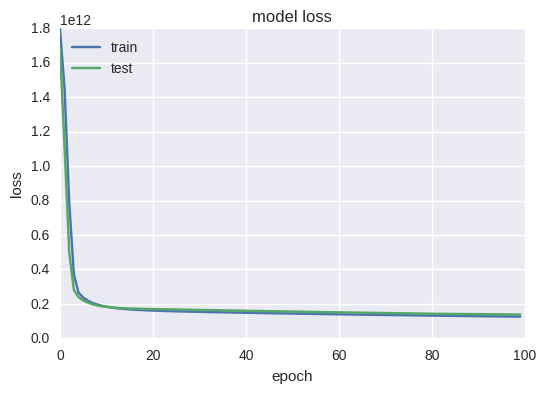

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [48]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate=.1, min_child_weight=1).fit(X_train, y_train)

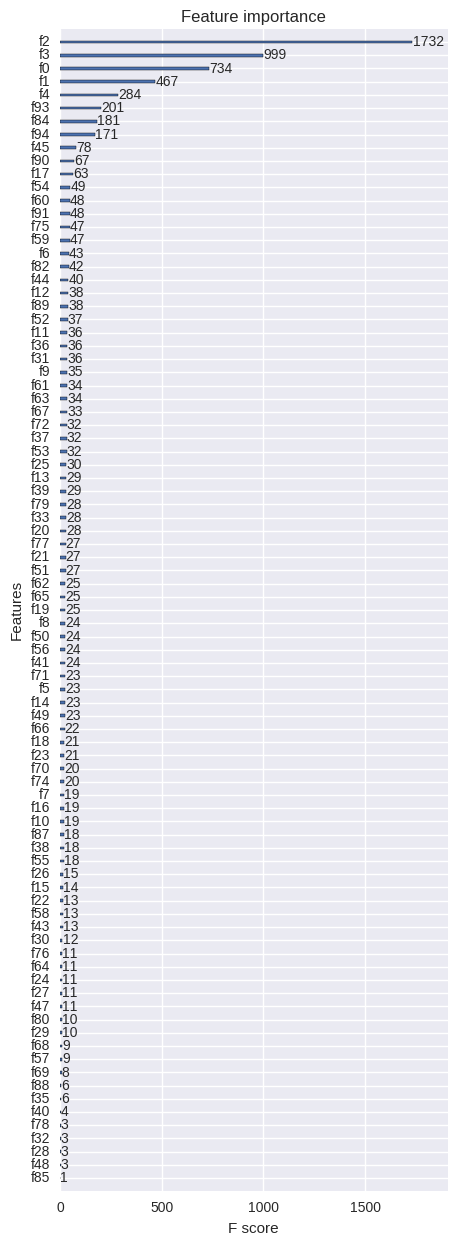

In [49]:

ax = plot_importance(xgb)
fig = ax.figure
fig.set_size_inches(5, 15)



In [155]:
y_pred = xgb.predict(X_test)

In [156]:
r2_score(y_test, y_pred)

0.75741698242313138

In [222]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

-7.4218854432450651e+22

In [54]:
xgb_model = XGBRegressor(n_estimators = 1000)
parameters = {
    'max_depth':[3, 6, 8],
    'min_child_weight':[1, 5, 10],
    'learning_rate': [0.1, 0.2, .3],
    'subsample': [0.5, 1.0]
}
clf = GridSearchCV(xgb_model, parameters, cv=2, 
                   scoring='r2', verbose=2, refit=True)

In [55]:
clf.fit(X_train, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1 -   0.1s
[CV] subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1 -   0.1s
[CV] subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1 -   0.1s
[CV] subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1 -   0.0s
[CV] subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 -   0.1s
[CV] subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  subsample=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 -   0.1s
[CV] subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5 -   0.0s
[CV] subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  subsample=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5 -   0.1s
[

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 11.3min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'subsample': [0.5, 1.0], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [3, 6, 8], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=2)

In [60]:
xgb_model = XGBRegressor(n_estimators = 1000)
parameters = {
    'gamma':[i/10.0 for i in range(0,5)]
}
clf = GridSearchCV(xgb_model, parameters, cv=5, 
                   scoring='r2', verbose=2, refit=True)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.0 .......................................................
[CV] .............................................. gamma=0.0 -   0.0s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] .............................................. gamma=0.0 -   0.0s
[CV] gamma=0.0 .......................................................
[CV] .............................................. gamma=0.0 -   0.0s
[CV] gamma=0.0 .......................................................
[CV] .............................................. gamma=0.0 -   0.0s
[CV] gamma=0.0 .......................................................
[CV] .............................................. gamma=0.0 -   0.0s
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 -   0.0s
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 -   0.0s
[CV] gamma=0.1 .......................................................
[CV] .............................................. gamma=0.1 -   0.0s
[CV] gamma=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=2)

In [61]:
clf.best_params_


{'gamma': 0.0}

In [154]:
y_pred2 = clf.predict(X_test)
r2_score(y_test, y_pred)

0.75741698242313138

<Container object of 2 artists>

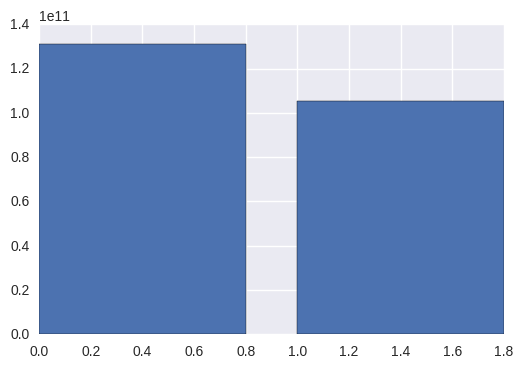

In [73]:
plt.bar(range(2), [130933298114.07002 ,105321334861.76054 ])

In [157]:
type(y_pred)

numpy.ndarray

In [173]:
arr = np.array([y_pred, y_pred2, y_test]) 

In [170]:
len(y_pred)

3272

In [171]:
avg = arr.mean(axis=0)

In [172]:
r2_score(y_test, avg)

0.75354431006218625

In [21]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression

In [31]:
xgb = XGBRegressor(n_estimators = 1000, learning_rate=.1, min_child_weight=1)
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose =0)
lr = LinearRegression()

In [32]:
stregr = StackingRegressor(regressors=[xgb, estimator], 
                           meta_regressor=lr)
stregr.fit(X_train, y_train)

StackingRegressor(meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         regressors=[XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1), <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fefd4d5dd90>],
         verbose=0)

In [33]:
y_pred = stregr.predict(X_test)
r2_score(y_test, y_pred)

0.72804803759416403

In [28]:
from sklearn.linear_model import LassoLars

In [29]:
ll = LassoLars()
stregr = StackingRegressor(regressors=[xgb, estimator], 
                           meta_regressor=ll)
stregr.fit(X_train, y_train)

StackingRegressor(meta_regressor=LassoLars(alpha=1.0, copy_X=True, eps=2.2204460492503131e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False),
         regressors=[XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1), <keras.wrappers.scikit_learn.KerasRegressor object at 0x7feffbffcc50>],
         verbose=0)

In [30]:
y_pred = stregr.predict(X_test)
r2_score(y_test, y_pred)

0.73047521944132443